# Introduction to time series strategies in Finance

#### by Gustavo Soares

This note book introduces the use of time series strategies quantitative strategies. Also, in this notebook you will apply a few things you learned in the [FinanceHub's Python lectures](https://github.com/Finance-Hub/FinanceHubMaterials/tree/master/Python%20Lectures) as well as in the [FinanceHub's Quantitative Finance Lectures](https://github.com/Finance-Hub/FinanceHubMaterials/tree/master/Quantitative%20Finance%20Lectures).

## What is a time series strategy?

The distinctive feature of time series strategies is that they focus on predicting the future excess returns of a **single** asset, index or exposure. For example, we discussed in our [Time series momentum notebook](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/time_series_momentum.ipynb) a trend-following strategy which is one of the most prevalent quantitative time series strategies. Trend-following strategies are applied frequently to several markets such as equity indices, currencies, and futures markets like commodities and bond futures. Trend-following (or Time Series Momentum) refers to the predictability of the past returns on future returns and is the focus of several influential studies. The best overall academic summary of trend-following can be found on in the paper [Moskowitz, Ooi, and Pedersen (2012)](https://doi.org/10.1016/j.jfineco.2011.11.003) where the authors document significant momentum in monthly returns.

Here, we generalize the cross-sectional vs. time-series momentum discussion in [Moskowitz, Ooi, and Pedersen (2012)](https://doi.org/10.1016/j.jfineco.2011.11.003) following the discussion in [Baz, Granger, Harvey, Le Roux, and Rattray (2015)](https://www.cmegroup.com/education/files/dissecting-investment-strategies-in-the-cross-section-and-time-series.pdf) where they contrast the time-series and cross-sectional performance of three popular investment strategies: carry, momentum and value. They also discuss circumnstances in which time series strategies would be preferable (or not) to cross-sectional strategies.


## Future returns

We want to predict *future* returns, from the trade date, $t$, over a certain investment horizon, $h$. In other words, we want to predict the returns over the period $t$ to $t+h$, $R_{t+h}$, which will be calculated using prices, valuations or index levels $P_{t}$ and $P_{t+h}$ as in $R_{t+h} \equiv P_{t+h}/P_{t}-1$ or along the lines our Jupyter Notebooks on financial time series for [trading currencies](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/creating_fx_time_series_fh.ipynb), [futures](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/rolling_futures_time_series.ipynb), and [interest rates swaps](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/swap_historical_returns.ipynb)!

## Signal calculation with a time gap

Here, we will abstract a bit on whether we are using carry, momentum or value as our factor and think about a scalar signal, $S_{i,t}$. It is important that whatever the signal is, it needs to be obtained using one or several characteristics of the asset $i$ using data available up to a time $t - l$ where $l>0$ and $l$ denotes the time gap or lag necessary in between collecting the data (and calculating the signal $S_{i,t}$) and the actual trade date/time $t$. The *strict* inequality $l>0$ is *very* important! You cannot build a realistic quantitative strategy assuming you can calculate the signal $S_{i,t}$ using data up to time $t$ and trade at prices prevalent at time $t$, say $P_{t}$. The signal $S_{i,t}$ need to be calculated using data up to time $t - l$ and $l$ can be a lag of a few seconds, minutes, a day, a week, or really anything, depending on the application. Typically, we will think of $l$ as being equal to a single business day. We could make this all more explicit by saying that we are using signal $S_{i,t-l}$ to predict returns $R_{t+h}$. However, just for notational simplicity we will drop the lag time, $l$, from the notation but keep in mind that $S_{i,t}$ is calculated at time $t - l$.

## Getting started

We begin by setting up all of the necessary bits required to run our notebook. To start that means loading all of the Python modules we will need and the original data:

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Getting the signal data

Here we will use the example of FX trading to illustrate how classifiers work and contrast the results with standard linear regressions. We have discussed previously the three main types of signals in FX trading:
[carry](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/carry.ipynb), [momentum](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/time_series_momentum.ipynb) and [value](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/ppp_value_in_fx.ipynb). So, let's start by getting the data on these three types of signals.

For each signal $s$ for $s \in \{carry,momentum,value\}$ we have a value $x_{s,i,t}$ containing the signal $s$ for currency $i$ at time $t$ already appropriately lagged. Remember, that we need to make sure $x_{s,i,t}$ is only using information that was available at the time of trading to predict h-period returns from time $t$ to some time in the future $t+h$. So, the value $x_{s,i,t}$ needs to be calculated using information prior to $t$. Here, we lag the information set by one period and calculate $x_{s,i,t}$ only with information contained in $\mathscr{I}_{t-1}$.

In [2]:
carry_df = pd.read_excel(r'fx_trackers_and_signals.xlsx',sheetname='carry',index_col=0)
print('carry data has %s currencies and %s dates' % (carry_df.shape[1],carry_df.shape[0]))
mom_df = pd.read_excel(r'fx_trackers_and_signals.xlsx',sheetname='momentum',index_col=0)
print('momentum data has %s currencies and %s dates' % (mom_df.shape[1],mom_df.shape[0]))
value_df = pd.read_excel(r'fx_trackers_and_signals.xlsx',sheetname='value',index_col=0)
print('value data has %s currencies and %s dates' % (value_df.shape[1],value_df.shape[0]))

C:\Users\Gustavo\Anaconda3\lib\site-packages\pandas\util\_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


carry data has 24 currencies and 4973 dates
momentum data has 24 currencies and 4968 dates
value data has 24 currencies and 4973 dates


## Getting the trackers data

We also discussed how to construct [FX trackers](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/creating_fx_time_series_fh.ipynb) for each currency against the USD. Here, we will just upload the data on the FX trackers.

In [3]:
trackers_df = pd.read_excel(r'fx_trackers_and_signals.xlsx',sheetname='trackers',index_col=0)
print('trackers data has %s currencies and %s dates' % (trackers_df.shape[1],trackers_df.shape[0]))

trackers data has 24 currencies and 5220 dates


## Creating a signal

The variable we want to predict is
$$
r_{i,t+h} \equiv \frac{I_{t+h}}{I_{t}}-1
$$

which contains the returns of currency $i$ over the period between $t$ and $t+h$ as measured by the percentage change in the the currency tracker level $I_{t}$ over the period. This assumes that we traded at level $I_{t}$ at inception and closed the position $I_{t+h}$. Let's use `Pandas` to create a dataframe containing these returns for $h=21$ business days.

In [4]:
h = 21
# note the use of the .shift(-h) method below to make sure that on the index t we have the returns from t to t+h
returns_df = trackers_df.pct_change(h).shift(-h).dropna()
print('returns data has %s currencies and %s dates' % (returns_df.shape[1],returns_df.shape[0]))

returns data has 24 currencies and 2241 dates


Let's use the logistic regression model covered in Chapter 4 of [James, Witten, Hastie, and Tibshirani (2013)](http://faculty.marshall.usc.edu/gareth-james/ISL/) to create an estimate of:
$$
Prob(r_{i,t+h} \geqslant 0 | X_{i,t}) = \frac{e^{\gamma_{i} + \beta_{i}´X_{i,t}}}{1+e^{\gamma_{i} + \beta_{i}´X_{i,t}}}
$$

for each currency $i$ at time $t$. Also, check out our [notebook on classifiers](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/classifiers_fx_example.ipynb).

Note that we have to be careful here. If we estimate $Prob(r_{i,t+h} \geqslant 0 | X_{i,t})$ using $r_{i,t+h}$, our signal will in fact belong to $\mathscr{I}_{t+h}$ and not to $\mathscr{I}_{t-1}$ like we want to. What we need to do is to estimate the model using data all the way up to $\mathscr{I}_{t-1}$.

In [5]:
import statsmodels.api as sm
signal = pd.DataFrame()
for ccy in trackers_df.columns:
    print('Running currency %s' % ccy, end="\r")
    y = (1*(returns_df[ccy]>=0)).to_frame('returns')
    
    # get the three signals
    X_carry = carry_df[ccy].dropna().to_frame('carry')
    X_mom = mom_df[ccy].dropna().to_frame('mom')
    X_value = value_df[ccy].dropna().to_frame('value')
    
    # make sure the signals are lined up and fill the nan's with the last obs in case there are some
    X = pd.concat([X_carry,X_mom,X_value],join='outer',axis=1,sort=True).fillna(method='ffill').dropna()
    X = sm.add_constant(X)
    
    # make sure the dates of the signals and future returns line up
    yX = pd.concat([y,X],axis=1,sort=True).dropna()
    prob_market_going_up = pd.Series(index=yX.index[3*252:])
    
    # loop over days
    for d in prob_market_going_up.index:
        # get past data for signal calculation
        past_returns_indicator = yX.iloc[:,0].loc[:d]
        past_features = yX.iloc[:,1:].loc[:d]
        
        # fit the model using Logit but do not use the last h observations to make sure we are using the right information set
        model = sm.Logit(past_returns_indicator.shift(h).dropna(), past_features.shift(h).dropna()).fit(disp=False)
    
        # now use current features to predict the market
        current_features = past_features.ewm(halflife=63).mean().iloc[-1] # note here the EWMA smoothing here
        prob_market_going_up[d]= model.predict([current_features])[0]
    
    signal = pd.concat([signal,prob_market_going_up.to_frame(ccy)],join='outer',axis=1,sort=True)

signal = signal.fillna(method='ffill')

C:\Users\Gustavo\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## Creating a backtest

Now, for every time $t$ we have an estimate, $p_{i,t}$, of $Prob(r_{i,t+h} \geqslant 0 | X_{i,t})$ estimated with data in $\mathscr{I}_{t-1}$. If we make a trading decision of going long or short currency $i$ based on $p_{i,t}$, we will trade the currency tracker the currency tracker level $I_{t}$, hold it for $h$ amount of days and get out of the trade at level $I_{t+h}$.

Let's decide we want to builds a strategy with the following characteristics:

1. Every week, we will look at the estimate $p_{i,t}$ and decide to go long currency $i$ if $p_{i,t}>0.6$, go short if $p_{i,t}>0.4$ and be neutral otherwise. 
2. Following [Moskowitz, Ooi, and Pedersen (2012)](https://doi.org/10.1016/j.jfineco.2011.11.003) we will set up each trade to have a targeted volatility of 40%.

Let's run the backtest:

In [10]:
trackers_df = trackers_df.fillna(method='ffill')
# initial set up
backtest = pd.Series(index=signal.index)
backtest.iloc[0] = 100 # initialize the backtest with 100
start_date = signal.index[0]

# first trade
vols = np.log(trackers_df.loc[:start_date]).diff(1).ewm(halflife=60).std()*np.sqrt(252)
positions = 1*(signal.iloc[0]>0.6) + -1*(signal.iloc[0]<0.4)
prices = trackers_df.loc[:start_date].iloc[-1]
holdings = ((0.4/vols.iloc[-2])*positions)*(backtest.iloc[0]/prices)

# loop over the next days
for i in range(1,len(signal)): # loop over all the signals
    tdy = signal.index[i]
    yst = signal.index[i-1]
    
    # calculate pnl on the day
    price_change = trackers_df.loc[:tdy].iloc[-1] - trackers_df.loc[:yst].iloc[-1]
    pnl = (holdings*price_change).mean()
    backtest.iloc[i] = backtest.iloc[i-1] + pnl
    
    if tdy.week != yst.week: # check if it's a new week and reasses trades if so        
        vols = np.log(trackers_df.loc[:tdy]).diff(1).ewm(halflife=60).std()*np.sqrt(252)
        positions = 1*(signal.iloc[i]>0.6) + -1*(signal.iloc[i]<0.4)
        prices = trackers_df.loc[:tdy].iloc[-1]
        holdings = ((0.4/vols.iloc[-2])*positions)*(backtest.iloc[i]/prices)                

Let's now visualize what we have:

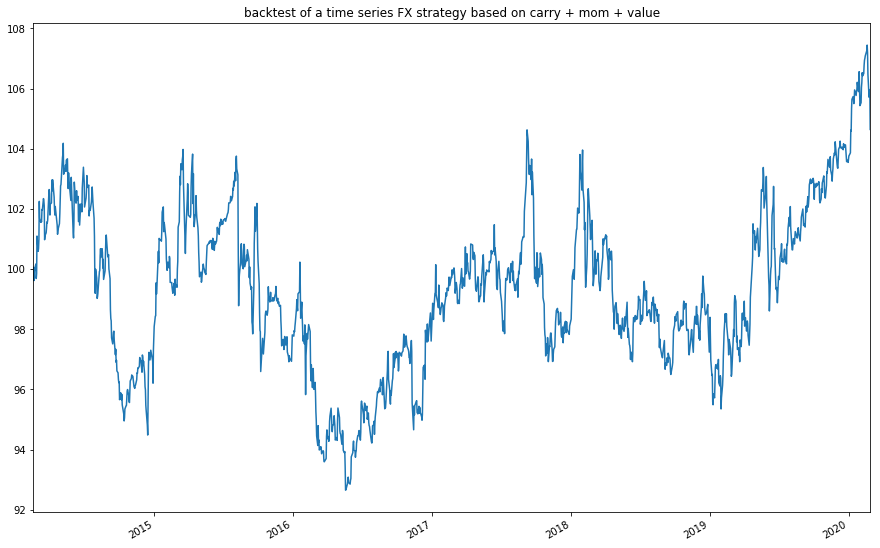

In [11]:
backtest.plot(title='backtest of a time series FX strategy based on carry + mom + value',figsize=(15,10))

# Exercises

## Beginners

Play around with the strategy described in this notebook and see if you can change things around. Maybe run separate strategies for G10 and EM. Trying rebalancing more frequenty or less frequently.

## Intermediate

Try using other types of [classifiers](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/classifiers_fx_example.ipynb) or simply different signal combinations.

## Advanced

The strategy here is constructed with weights that are inversely proportional to volatility. So, it does not consider co-movement across currencies. Construct a time-series strategy that makes the use of risk-parity principles described in [Baltas (2015)](https://www.sciencedirect.com/science/article/pii/B9781785480089500034?via%3Dihub) and see if you get the same enhancements in performance of the strategy as he does.